<a href="https://colab.research.google.com/github/jiobu1/DS-Unit-2-Kaggle-Challenge/blob/master/Jisha_Obukwelu_DSPT3_224_Kaggle_Challenge_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)
- [ ] Stacking Ensemble. (See below)

### Stacking Ensemble

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

### Imports

In [0]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from math import radians, cos, sin, asin, sqrt
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

### Train/Val/Test

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [73]:
# Train/Validate/Test split the data
train, val = train_test_split(
    train, train_size=len(test),
    stratify=train['status_group'], random_state=42
)

train.shape, val.shape, test.shape

((14358, 41), (45042, 41), (14358, 40))

### Feature Engineering

In [0]:
def single_pt_haversine(lat, lng, degrees=True):
    """
    'Single-point' Haversine: Calculates the great circle distance
    between a point on Earth and the (0, 0) lat-long coordinate
    """
    r = 6371 # Earth's radius (km). Have r = 3956 if you want miles

    # Convert decimal degrees to radians
    if degrees:
        lat, lng = map(radians, [lat, lng])

    # 'Single-point' Haversine formula
    a = sin(lat/2)**2 + cos(lat) * sin(lng/2)**2
    d = 2 * r * asin(sqrt(a)) 

    return d

In [0]:
# Cluster the locations
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, n_jobs=-1)
train['cluster'] = kmeans.fit_predict(train[['longitude', 'latitude']])
val['cluster'] = kmeans.predict(val[['longitude', 'latitude']])
test['cluster'] = kmeans.predict(test[['longitude', 'latitude']])

In [0]:
def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()

    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                        'population', 'gps_height']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type', 'id']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (all the same), id (can't glean useful info), num_private(mostly 0s)
    unused = ['recorded_by']
    X = X.drop(columns=unused)

    # Changing region and district code into categories rather than ints
    X['region_code'] = X['region_code'].astype('str')
    X['district_code'] = X['district_code'].astype('str')

    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
   
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    #binning construction_years
    cut_bins = [0, 1, 1960, 1970, 1980, 1990, 2000, 2010, 2013]
    X['construction_bin'] = pd.cut(x=X['construction_year'], bins= cut_bins, include_lowest=True, duplicates='raise').values.add_categories('missing')
    X['construction_bin']=X['construction_bin'].fillna('missing')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years_till_check'] = X['year_recorded'] - X['construction_year']

    # Engineer feature: Age of waterpoint
    X['age'] = 2013 - X['construction_year']

    # Engineer feature: Water quality and quantity
    X['good_enough'] = ((X['quality_group'] == 'good') & (X['quantity'] == 'enough')).astype(int)
    
    # Engineer feature: Using lat and long features
    # Trying two ways to use the lat and long - haversine and 
    # https://datascience.stackexchange.com/questions/13567/ways-to-deal-with-longitude-latitude-feature
    # see which one works better for model
    X['x'] = np.cos(X['latitude']) * np.cos(X['longitude'])
    X['y'] = np.cos(X['latitude']) * np.sin(X['longitude'])
    X['z'] = np.sin(X['latitude'])

    # Engineer feature: Haversine point
    X['harvesine_distance'] = [single_pt_haversine(latitude, longitude) for latitude, longitude in zip(X['latitude'], X['longitude'])]

    # Engineer feature: gps_height
    X['gps_height_bins'] = pd.qcut(X['gps_height'], 10).astype(object)



    # Return the wrangled dataframe
    return X

# Wrangle train, validate, and test sets in the same way
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
def seasonality(X):
  X = X.copy()

  hot = (X['month_recorded'] == 11)
  hot = (X['month_recorded'] == 12)
  hot = (X['month_recorded'] == 1)
  hot = (X['month_recorded'] == 2)
  rain = (X['month_recorded'] == 3)
  rain = (X['month_recorded'] == 4)
  rain = (X['month_recorded'] == 5)
  cool = (X['month_recorded'] == 6)
  cool = (X['month_recorded'] == 7)
  cool = (X['month_recorded'] == 8)
  cool = (X['month_recorded'] == 9)
  cool = (X['month_recorded'] == 10)

  X['hot'] = hot
  X['rain'] = rain
  X['cool'] = cool

  return X

train = seasonality(train)
val = seasonality(val)
test = seasonality(test)

### Training/Testing Model

In [0]:
# Arrange data into X features matrix and y target vector
target = 'status_group'

X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

In [0]:
# Make pipeline!
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

In [86]:
# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

# Accuracy Score
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.7796945073486967


###Confusion Matrix

In [87]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred)

array([[21391,   520,  2550],
       [ 1847,   880,   547],
       [ 4248,   211, 12848]])

In [65]:
#Get the unique labels
from sklearn.utils.multiclass import unique_labels
unique_labels(y_val)

array(['functional', 'functional needs repair', 'non functional'],
      dtype='<U23')

In [44]:
!pip install scikit-plot

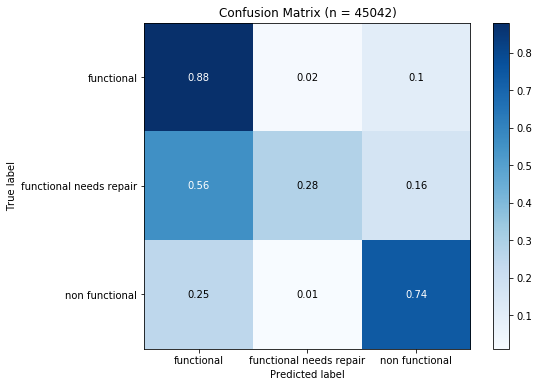

In [66]:
#Confusion Matrix Visual
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(y_val, y_pred,
                                    figsize=(8,6),
                                    title = f'Confusion Matrix (n = {len(y_val)})',
                                    normalize = True);

#https://github.com/mwaskom/seaborn/issues/1773
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show();

In [67]:
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.78      0.88      0.82     24461
functional needs repair       0.54      0.28      0.37      3274
         non functional       0.81      0.74      0.77     17307

               accuracy                           0.78     45042
              macro avg       0.71      0.63      0.65     45042
           weighted avg       0.77      0.78      0.77     45042



###Submission

In [0]:
assert all(X_train.columns == X_test.columns)

In [0]:
y_pred = pipeline.predict(X_test)

In [0]:
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('Obukwelu_DSPT3_Unit_2_submission5.csv', index=False)

In [90]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from google.colab import files
files.download('Obukwelu_DSPT3_Unit_2_submission5.csv')

In [48]:
submission.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,functional
4,49871,functional


In [49]:
submission.shape

(14358, 2)